AR signature in python
converted from Artem Sokolov and Vlado Uzunangelov's R code

In [221]:
import pandas as pd
import numpy as np
from sklearn import linear_model, kernel_ridge
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None # supress pandas copy-by-ref warning
%matplotlib inline

In [136]:
X_file = "data/AR_sig_celline.tab"
Y_file = "data/ar_cell_line_clin.txt"
X_WCDT_file = "data/filtered_mrna.tab"

X_df = pd.read_csv(X_file, delimiter="\t")
Y_df = pd.read_csv(Y_file, delimiter="\t")

# print(Y_df)

In [75]:
def data_prep(X_df, Y_df):
    # take "ligand" column as Y label and set "on" to 1 and "no ligand" to 0
    Y_df = Y_df[["GSM_ID", "ligand"]]
    Y_df['ligand'] = Y_df['ligand'].replace(['on'], 1)
    Y_df['ligand'] = Y_df['ligand'].replace(['no ligand'], 0)
    
    # Drop sample GSM288299, GSM288300, GSM288301 (QA by Robert and Jack)
    Y_df = Y_df[~Y_df.GSM_ID.isin(["GSM288299", "GSM288300", "GSM288301"])]
    
    # remove non-overlapping samples in X and Y
    common_samples = sorted(list(set(Y_df.GSM_ID).intersection(set(X_df.columns[1:]))))
    X_df = X_df[["Gene Symbol"] + common_samples]
    Y_df = Y_df[Y_df.GSM_ID.isin(common_samples)]
    
    # remove genes with NA
    X_df = X_df.dropna()
    
    # get overlap of genes between X_df and WCDT file
    WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
    common_genes = set(WCDT_df["gene_id"]).intersection(set(X_df["Gene Symbol"]))
    X_df = X_df[X_df["Gene Symbol"].isin(common_genes)]
    
    # rank transformation + normalization (with quantile function of exponential distribution) 
    X_df.set_index("Gene Symbol", inplace=True)
    X_orig_df = X_df.copy()
    X_df = (X_df.rank()-1)/len(X_df)
    X_df = X_df.applymap(lambda x: -np.log(1-x))

    # transpose X
    X_df = X_df.transpose()
    X_orig_df = X_orig_df.transpose()
    
    # set GSM_id as Y index
    Y_df.set_index("GSM_ID", inplace=True)    
    
    
    return X_orig_df.as_matrix(), X_df, Y_df

In [76]:
_, X, Y = data_prep(X_df, Y_df)
print(X.shape, Y.shape)

(41, 11655) (41, 1)


In [237]:
def get_artem_sig():
    df1 = pd.read_csv("data/ar-sig.rnk", delimiter="\t", 
                      names=["gene","gelnet_ker"], index_col=0)
    df2 = pd.read_csv("data/ar-sig-gelnet.rnk", delimiter="\t", 
                      names=["gene","gelnet"], index_col=0)
    # scale both data set to [0, 1] by minmax scaling
    df = pd.concat([df1, df2], axis=1)  
    minmax = MinMaxScaler()
    df = pd.DataFrame(minmax.fit_transform(df), index=df.index,
                      columns=df.columns)    
    plt.figure(1)
    plt.scatter(df['gelnet_ker'], df['gelnet'])
    plt.xlabel("R gelnet.ker")
    plt.ylabel("R gelnet")
    plt.title("pearson correlation %s" 
              %stats.pearsonr(df['gelnet_ker'], df['gelnet'])[0])
    return df

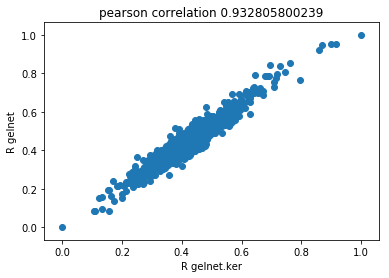

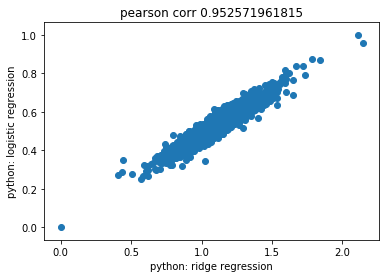

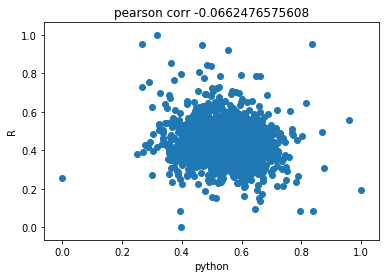

In [244]:
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               "Ridge": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
                }

sig_df = get_artem_sig()
classifiers['Ridge'].fit(X, Y['ligand'])
sig1 = classifiers['Ridge'].coef_
sig1 = (sig1 - min(sig1))/max(sig1)
classifiers['Logistic'].fit(X, Y['ligand'])
sig2 = (sig2 - min(sig2))/max(sig2)

plt.figure(2)
plt.scatter(sig1, sig2)
plt.title("pearson corr %s" %stats.pearsonr(sig1, sig2)[0])
plt.xlabel("python: ridge regression")
plt.ylabel("python: logistic regression")

plt.figure(3)
plt.scatter(sig2, sig_df['gelnet'])
plt.title("pearson corr %s" %stats.pearsonr(sig2, sig_df['gelnet'])[0])
plt.xlabel("python")
plt.ylabel("R")

In [247]:
# paired cross validatio

           ligand
GSM_ID           
GSM63051        0
GSM64845        0
GSM64852        1
GSM64855        0
GSM64858        0
GSM64859        1
GSM64861        0
GSM64864        0
GSM64865        1
GSM560828       0
GSM560829       0
GSM560830       0
GSM560831       1
GSM560832       1
GSM560833       1
GSM560834       0
GSM560835       0
GSM560836       0
GSM560837       1
GSM560838       1
GSM560839       1
GSM801007       0
GSM801008       1
GSM801009       0
GSM801010       1
GSM823844       1
GSM823845       0
GSM823846       0
GSM823847       0
GSM823848       1
GSM823849       1
GSM823850       1
GSM823851       0
GSM823852       0
GSM823853       1
GSM426518       0
GSM426519       0
GSM426520       0
GSM426521       1
GSM426522       1
GSM426523       1
